In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/kaggle/input/birdclef-2025/train.csv')
taxonomy = pd.read_csv('/kaggle/input/birdclef-2025/taxonomy.csv')
train.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [3]:
input_file = "/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg"
output_dir = "/kaggle/working/separated"
os.makedirs(output_dir, exist_ok=True)

In [6]:
# !pip install demucs

In [5]:
import subprocess
import shutil

# Run Demucs on the input file
command = f"demucs --out {output_dir} {input_file}"
subprocess.run(command, shell=True, check=True)

# Locate the extracted "other.wav" file
demucs_output = os.path.join(output_dir, "htdemucs", "CSA36385", "other.wav")
cleaned_output = "/kaggle/working/CSA36385_no_vocals.wav"

# Move the background audio file to the working directory
shutil.move(demucs_output, cleaned_output)

shutil.rmtree(output_dir)  

print(f"Cleaned audio saved at: {cleaned_output}")

Downloading: "https://dl.fbaipublicfiles.com/demucs/hybrid_transformer/955717e8-8726e21a.th" to /root/.cache/torch/hub/checkpoints/955717e8-8726e21a.th
  0%|          | 0.00/80.2M [00:00<?, ?B/s]

Important: the default model was recently changed to `htdemucs` the latest Hybrid Transformer Demucs model. In some cases, this model can actually perform worse than previous models. To get back the old default model use `-n mdx_extra_q`.


100%|██████████| 80.2M/80.2M [00:00<00:00, 165MB/s] 


Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /kaggle/working/separated/htdemucs
Separating track /kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg


100%|████████████████████████████████████████████████| 99.44999999999999/99.44999999999999 [02:02<00:00,  1.24s/seconds]


Cleaned audio saved at: /kaggle/working/CSA36385_no_vocals.wav


In [9]:
### enhance sonidos de mabiente

from pydub import AudioSegment, effects

# Cargar el audio separado
audio = AudioSegment.from_wav("/kaggle/working/CSA36385_no_vocals.wav")

# Aplicar normalización para elevar el volumen general
normalized_audio = effects.normalize(audio)

# Opcional: Aplicar un filtro para subir agudos (donde suelen estar los sonidos de aves, por ejemplo)
from pydub.effects import high_pass_filter
filtered_audio = high_pass_filter(normalized_audio, cutoff=2000)  # resalta frecuencias por encima de 2kHz

# Exportar el audio mejorado
output_path = f"{output_dir}_ambiente_mejorado.wav"
filtered_audio.export(output_path, format="wav")

print(f"Audio mejorado guardado en: {output_path}")


Audio mejorado guardado en: /kaggle/working/separated_ambiente_mejorado.wav


In [11]:
!pip install webrtcvad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp311-cp311-linux_x86_64.whl size=73494 sha256=25dcb7f9abed67b49a7789f59ca94745ed6b9b51cafb95d32fcb90f90ebab66a
  Stored in directory: /root/.cache/pip/wheels/94/65/3f/292d0b656be33d1c801831201c74b5f68f41a2ae465ff2ee2f
Successfully built webrtcvad


#### try to cut the audio without voices

works great for the most part, there are still remaining voices in the audio, but with harshr parameters, the animal sound was lost with the voice

In [37]:
import webrtcvad
import wave
import contextlib
from pydub import AudioSegment
import os


ogg_path = "/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg"
converted_path = "/kaggle/working/CSA36385_original.wav"

# Convertir y guardar
audio = AudioSegment.from_ogg(ogg_path)
audio = audio.set_channels(1).set_frame_rate(16000)
audio.export(converted_path, format="wav")


# Ruta del archivo original separado por Demucs sin voces
input_audio_path = converted_path

# Convertimos a mono, 16kHz, 16-bit PCM
audio = AudioSegment.from_wav(input_audio_path)
audio = audio.set_channels(1).set_frame_rate(16000)
temp_wav_path = "/kaggle/working/temp_vad_input.wav"
audio.export(temp_wav_path, format="wav", parameters=["-acodec", "pcm_s16le"])


# Parámetros de VAD
frame_duration = 10  # ms (válidos: 10, 20, 30)
vad = webrtcvad.Vad(3) # param set to 3 --> to keep the animal audio

# Calcular tamaño correcto del frame
with contextlib.closing(wave.open(temp_wav_path, 'rb')) as wf:
    sample_rate = wf.getframerate()
    bytes_per_sample = wf.getsampwidth()
    num_channels = wf.getnchannels()
    assert sample_rate in (8000, 16000, 32000, 48000)
    assert bytes_per_sample == 2
    assert num_channels == 1

    frame_length = int(sample_rate * frame_duration / 1000)  # en frames
    non_speech_segments = []

    offset = 0
    while True:
        frame = wf.readframes(frame_length)
        if len(frame) < frame_length * bytes_per_sample:
            break  # fin del archivo
        is_speech = vad.is_speech(frame, sample_rate)
        if not is_speech:
            start_ms = offset * frame_duration
            end_ms = start_ms + frame_duration
            non_speech_segments.append((start_ms, end_ms))
        offset += 1

# Volver a cargar con pydub
original = AudioSegment.from_wav(temp_wav_path)
ambiente = AudioSegment.empty()
for start, end in non_speech_segments:
    ambiente += original[start:end]

# 🔊 Normalizar y amplificar ###### opcional #######
ambiente = effects.normalize(ambiente)
ambiente += 5  # opcional: boost final ###### variable #######

# Guardar resultado
output_path = "/kaggle/working/solo_ambiente.wav"
ambiente.export(output_path, format="wav")
os.remove(temp_wav_path)

print(f"✅ Audio sin partes habladas guardado como: {output_path}")


✅ Audio sin partes habladas guardado como: /kaggle/working/solo_ambiente.wav


graficar el audio

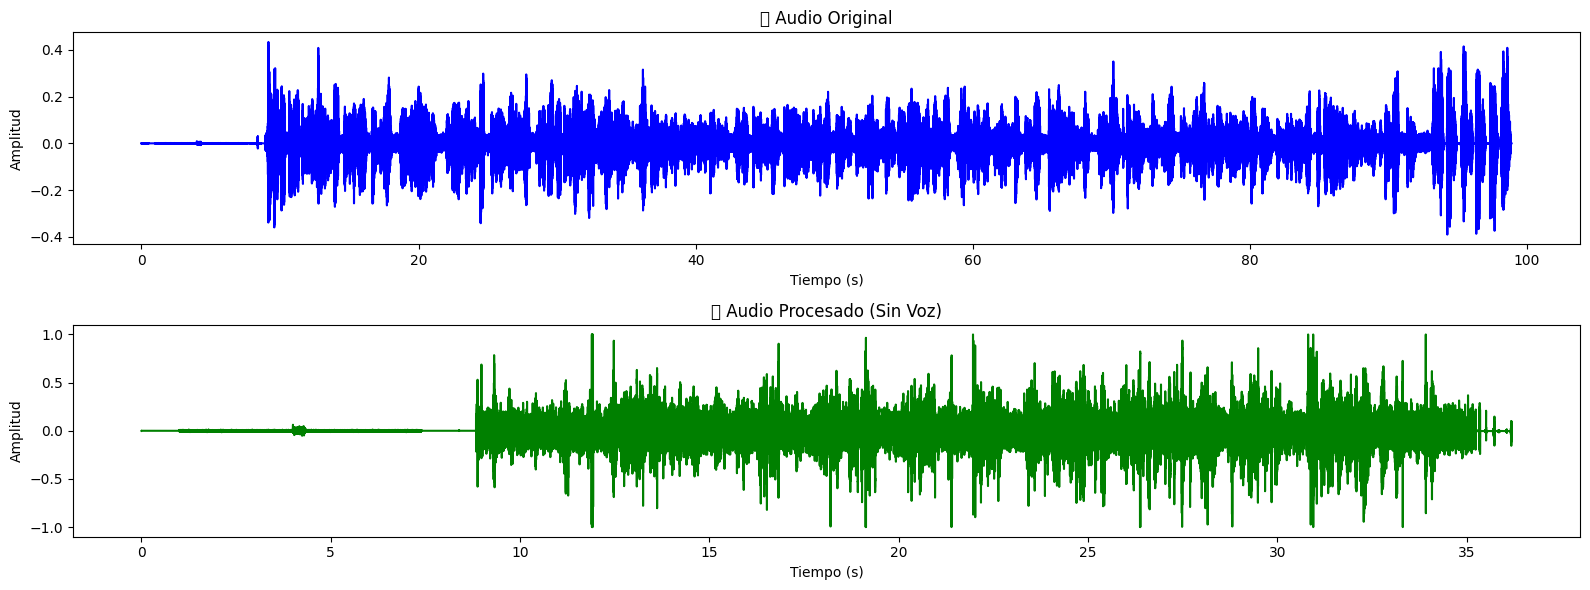

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

def audio_to_np(audio: AudioSegment):
    samples = np.array(audio.get_array_of_samples())
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
        samples = samples.mean(axis=1)  # convert to mono for plotting
    return samples / np.iinfo(samples.dtype).max  # normalize to -1..1

# Cargar audios
original_path = "/kaggle/working/CSA36385_original.wav"
procesado_path = "/kaggle/working/solo_ambiente.wav"

audio_original = AudioSegment.from_wav(original_path)
audio_procesado = AudioSegment.from_wav(procesado_path)

# Convertir a arrays
samples_original = audio_to_np(audio_original)
samples_procesado = audio_to_np(audio_procesado)

# Crear ejes de tiempo
t_original = np.linspace(0, len(audio_original) / 1000, num=len(samples_original))
t_procesado = np.linspace(0, len(audio_procesado) / 1000, num=len(samples_procesado))

# Graficar
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.plot(t_original, samples_original, color='blue')
plt.title("🔊 Audio Original")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.subplot(2, 1, 2)
plt.plot(t_procesado, samples_procesado, color='green')
plt.title("🧼 Audio Procesado (Sin Voz)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()


In [39]:
#hooa

### Mel-spectrograma

Cada línea horizontal es una frecuencia.
Un chorro de color fuerte indica energía en esa frecuencia.
Si hay un chirrido de pájaro o animal, va a aparecer como una franja breve y marcada (a menudo en frecuencias altas).

In [25]:
# !pip install librosa matplotlib

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Cargar el audio original
audio_path = "/kaggle/working/CSA36385_original.wav"
y, sr = librosa.load(audio_path, sr=16000)  # 'y' = señal, 'sr' = sample rate

# Calcular el mel-spectrograma
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=128)

# Convertir a decibeles (más interpretable visualmente)
S_dB = librosa.power_to_db(S, ref=np.max)

# Visualizar
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("🎼 Mel-spectrograma del audio original")
plt.show()
